# <center> <b> <span style="color:RED;"> TOPOLOGICAL DATA ANALYSIS </span> </b></center>


## <center> <b> <span style="color:blue;"> GROUP 11  </span> </b></center>

## <center> <b> <span style="color:orange;">Project 3 </span> </b></center>

# <center> <b> <span style="color:green;">SIGNAL PROCESSING </span> </b></center>

## <b> <span style="color:green;">GROUP MEMBERS: </span> </b>
 - Emmanuel Ansah
 - Linda INGABIRE
 - Josue TWAHIRWA
 - Miarisoa Elalie RASAMIMANANA

In [11]:
# data wrangling
import numpy as np
import pandas as pd
from pathlib import Path
from IPython.display import YouTubeVideo
from fastprogress import progress_bar

# hepml
from hepml.core import make_gravitational_waves, download_dataset

# tda magic
from gtda.homology import VietorisRipsPersistence, CubicalPersistence
from gtda.diagrams import PersistenceEntropy, Scaler
from gtda.plotting import plot_heatmap, plot_point_cloud, plot_diagram
from gtda.pipeline import Pipeline
from gtda.time_series import TakensEmbedding
from gtda.time_series import SingleTakensEmbedding

# ml tools
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

# dataviz
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(color_codes=True)
sns.set_palette(sns.color_palette("muted"))

# Using tqdm for progress bar
from tqdm import tqdm  

from ripser import ripser
from persim import plot_diagrams

import matplotlib.pyplot as plt
import numpy as np
import wave
import scipy.io.wavfile
import sys
import os

In [2]:
# Define the path to the directory containing the .wav files
normal_dir = "C:/Users/educa/Desktop/Anaconda/AIMS/Course/TDA/Project_3/Normal/"
asthma_dir = "C:/Users/educa/Desktop/Anaconda/AIMS/Course/TDA/Project_3/Asthma/"

In [3]:
def visualize_waveforms(normal_dir, asthma_dir, num_samples=5):
    """
    Visualize the first `num_samples` waveforms from both normal and asthma folders.
    """
    fig, axs = plt.subplots(num_samples, 2, figsize=(15, 10))
    fig.suptitle("Audio Waveforms Comparison", fontsize=16)
    
    normal_files = [f for f in os.listdir(normal_dir) if f.endswith('.wav')][:num_samples]
    for i, file in enumerate(normal_files):
        Fs, X = scipy.io.wavfile.read(os.path.join(normal_dir, file))
        axs[i, 0].plot(np.arange(len(X)) / float(Fs), X)
        axs[i, 0].set_title(f"Normal: {file}")
        axs[i, 0].set_xlabel("Time (s)")
    
    asthma_files = [f for f in os.listdir(asthma_dir) if f.endswith('.wav')][:num_samples]
    for i, file in enumerate(asthma_files):
        Fs, X = scipy.io.wavfile.read(os.path.join(asthma_dir, file))
        axs[i, 1].plot(np.arange(len(X)) / float(Fs), X)
        axs[i, 1].set_title(f"Asthma: {file}")
        axs[i, 1].set_xlabel("Time (s)")
    
    plt.tight_layout()
    plt.show()

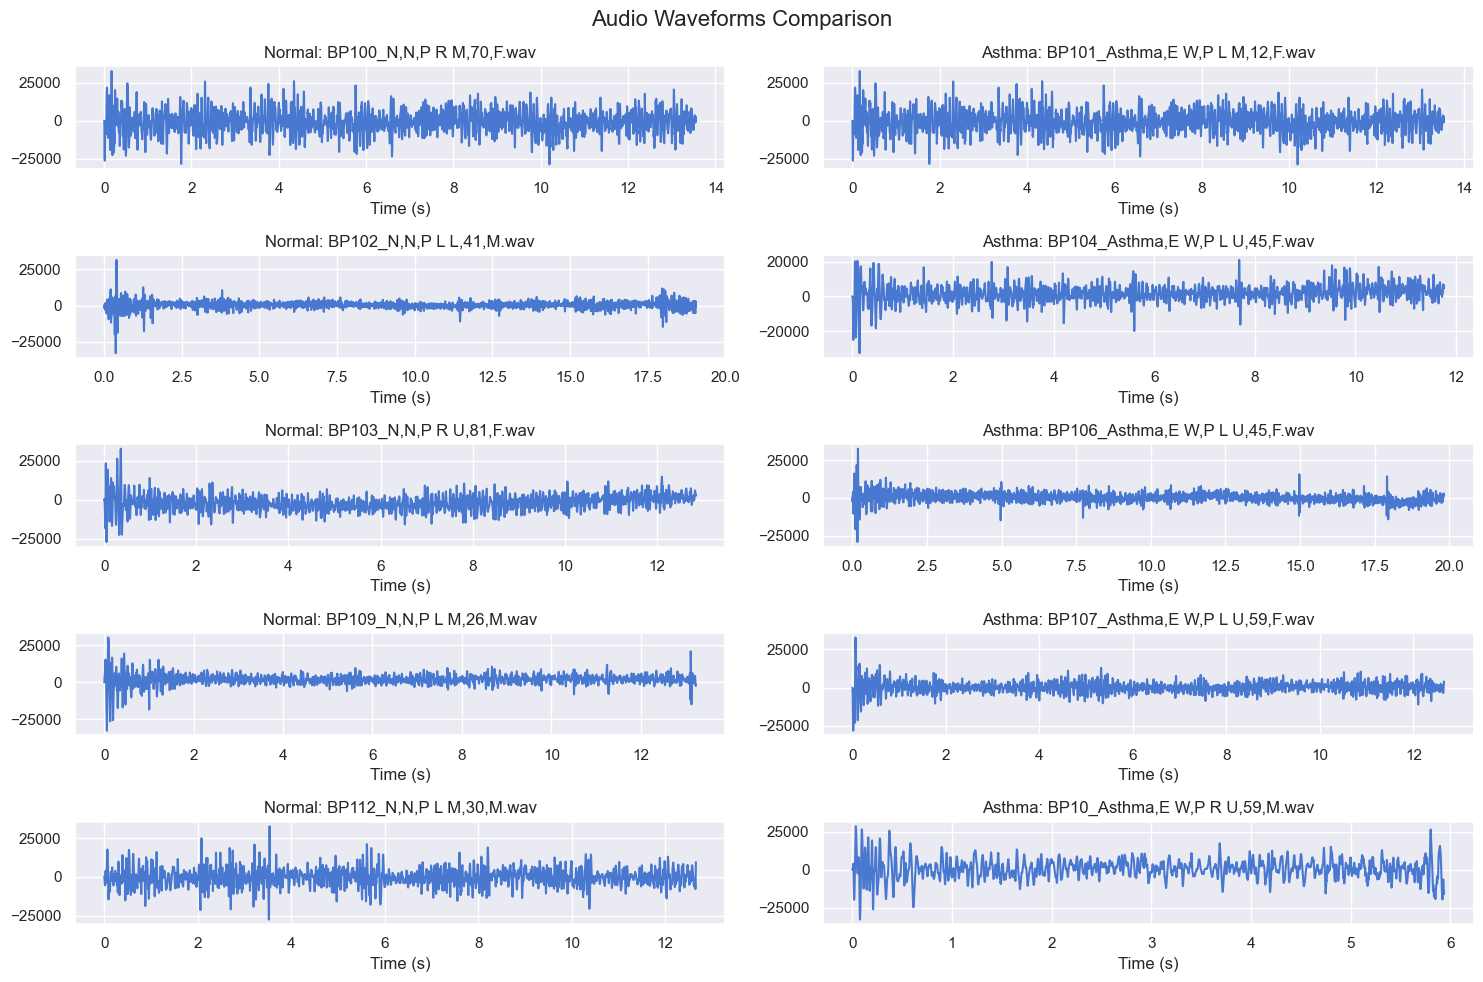

In [6]:
# Visualize waveforms
visualize_waveforms(normal_dir, asthma_dir, num_samples=5)

In [7]:
# Load and label the WAV files
def fetch_audio_files(normal_dir, asthma_dir):
    """Load WAV files from directories and assign labels."""
    normal_audio = [os.path.join(normal_dir, f) for f in os.listdir(normal_dir) if f.endswith('.wav')]
    asthma_audio = [os.path.join(asthma_dir, f) for f in os.listdir(asthma_dir) if f.endswith('.wav')]

    audio_signals = []
    audio_labels = []

    # Process normal audio files and assign label 0
    for audio in normal_audio:
        with wave.open(audio, 'r') as wav_file:
            raw_signal = wav_file.readframes(-1)
            decoded_signal = np.frombuffer(raw_signal, np.int16)
            audio_signals.append(decoded_signal)
            audio_labels.append(0)

    # Process asthma audio files and assign label 1
    for audio in asthma_audio:
        with wave.open(audio, 'r') as wav_file:
            raw_signal = wav_file.readframes(-1)
            decoded_signal = np.frombuffer(raw_signal, np.int16)
            audio_signals.append(decoded_signal)
            audio_labels.append(1)

    return audio_signals, audio_labels

In [9]:
# Load the full dataset
dataset_signals, dataset_labels = fetch_audio_files(normal_dir, asthma_dir)

In [52]:
# Embedding and PCA
embed_dim = 30
time_lag = 300
step_size = 15
point_cloud_list = []
fixed_cloud_size = 50  # Fixed number of points per point cloud

# Process the entire dataset
for index in tqdm(range(len(dataset_signals)), desc="Processing Dataset"):
    takens_embedder = SingleTakensEmbedding(
        parameters_type="fixed",
        n_jobs=8,
        time_delay=time_lag,
        dimension=embed_dim,
        stride=step_size
    )
    pca_reducer = PCA(n_components=3)
    embedded_signal = takens_embedder.fit_transform(dataset_signals[index])
    reduced_signal = pca_reducer.fit_transform(embedded_signal)
    
    # Ensure consistent shape for all point clouds
    if len(reduced_signal) > fixed_cloud_size:
        reduced_signal = reduced_signal[:fixed_cloud_size]  # Truncate if too large
    elif len(reduced_signal) < fixed_cloud_size:
        padding = fixed_cloud_size - len(reduced_signal)
        reduced_signal = np.pad(reduced_signal, ((0, padding), (0, 0)), mode='constant')  # Pad with zeros
    
    point_cloud_list.append(reduced_signal)

print(f"Total point clouds generated: {len(point_cloud_list)}")

Processing Dataset: 100%|████████████████████████████████████████████████████████████| 201/201 [00:07<00:00, 25.47it/s]

Total point clouds generated: 201


In [53]:
def calculate_homology_persistence(cloud_list, max_hom_dim=1, sample_points=700):
    """
    Compute persistent homology for a collection of point clouds.
    :param cloud_list: List of point clouds (transformed signals).
    :param max_hom_dim: Maximum homology dimension.
    :param sample_points: Default number of points for subsampling.
    :return: Collection of persistence diagrams.
    """
    homology_diagrams = []

    for cloud in tqdm(cloud_list, desc="Computing Persistence Diagrams"):
        # Ensure sample_points does not exceed the size of the current cloud
        effective_points = min(sample_points, len(cloud))
        
        # Compute persistent homology using Ripser
        homology_result = ripser(cloud, maxdim=max_hom_dim, n_perm=effective_points)
        diagrams = homology_result['dgms']
        
        # Filter out rows containing infinity values in each persistence diagram
        filtered_diagrams = [diagram[~np.isinf(diagram).any(axis=1)] for diagram in diagrams]
        
        homology_diagrams.append(filtered_diagrams)

    return homology_diagrams

In [54]:
# Compute persistent homology
diagrams_collection = calculate_homology_persistence(point_cloud_list)

# Display an example persistence diagram for the first signal
print("Sample Persistence Diagram for the first transformed signal:")
print(diagrams_collection[0])

Computing Persistence Diagrams: 100%|███████████████████████████████████████████████| 201/201 [00:00<00:00, 403.25it/s]

Sample Persistence Diagram for the first transformed signal:
[array([[   0.        , 1405.95080566],
       [   0.        , 1590.08251953],
       [   0.        , 1873.25      ],
       [   0.        , 2055.46362305],
       [   0.        , 2121.24633789],
       [   0.        , 2128.35839844],
       [   0.        , 2287.92382812],
       [   0.        , 2836.37988281],
       [   0.        , 2837.20410156],
       [   0.        , 2892.58666992],
       [   0.        , 3019.72192383],
       [   0.        , 3020.27416992],
       [   0.        , 3042.58691406],
       [   0.        , 3114.04980469],
       [   0.        , 3155.47192383],
       [   0.        , 3342.6105957 ],
       [   0.        , 3370.3527832 ],
       [   0.        , 3413.5871582 ],
       [   0.        , 3565.15136719],
       [   0.        , 3583.60546875],
       [   0.        , 3591.91357422],
       [   0.        , 3700.62792969],
       [   0.        , 3924.40380859],
       [   0.        , 4054.54418945],
  

#### Plotting the first value in the list

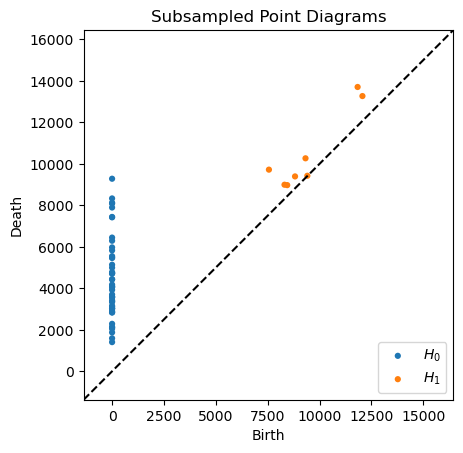

In [55]:
# Select a subset of diagrams to plot
dgms_sub = diagrams_collection[0]  

# Plot the persistence diagrams
plot_diagrams(dgms_sub)
plt.title("Subsampled Point Diagrams")
plt.show()

#### Plotting the second value in the list

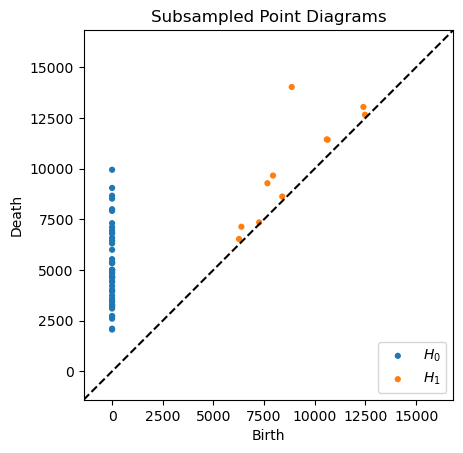

In [56]:
# Select a subset of diagrams to plot
dgms_sub = diagrams_collection[1]  

# Plot the persistence diagrams
plot_diagrams(dgms_sub)
plt.title("Subsampled Point Diagrams")
plt.show()

In [57]:
dgms_sub[0].shape

(49, 2)

In [58]:
dgms_sub[1].shape

(11, 2)

In [59]:
def convert_dgm(dgm):
    Arr = dgm.copy()
    Arr[0] = Arr[0][:-1]
    col_a  = np.zeros(Arr[0].shape[0])
    Arr[0] = np.column_stack((Arr[0], col_a))
    
    col_b  = np.ones(Arr[1].shape[0], dtype=int)
    Arr[1] = np.column_stack((Arr[1], col_b))
    temp_1 = list(Arr[0])
    temp_2 = list(Arr[1])
    temp_1.extend(temp_2)
    return np.asarray(temp_1)

In [60]:
res = convert_dgm(dgms_sub)
res.shape

(59, 3)

In [61]:
res[None,:,:].shape

(1, 59, 3)

## Generating topological features for classification

> ### Persistent Entropy

In [62]:
from gtda.diagrams import PersistenceEntropy

persistence_entropy = PersistenceEntropy()

# calculate topological feature matrix
X_pe = persistence_entropy.fit_transform(res[None,:,:])

X_pe.shape

(1, 2)

In [63]:
X_pe

array([[5.49521866, 2.66343679]])

> ### Carlsson Coordinates

In [64]:
diagrams_collection = calculate_homology_persistence(point_cloud_list)

# Check the first persistence diagram
print("First Persistence Diagram (H0 and H1):")
print(diagrams_collection[0])

Computing Persistence Diagrams: 100%|███████████████████████████████████████████████| 201/201 [00:00<00:00, 381.24it/s]

First Persistence Diagram (H0 and H1):
[array([[   0.        , 1405.95080566],
       [   0.        , 1590.08251953],
       [   0.        , 1873.25      ],
       [   0.        , 2055.46362305],
       [   0.        , 2121.24633789],
       [   0.        , 2128.35839844],
       [   0.        , 2287.92382812],
       [   0.        , 2836.37988281],
       [   0.        , 2837.20410156],
       [   0.        , 2892.58666992],
       [   0.        , 3019.72192383],
       [   0.        , 3020.27416992],
       [   0.        , 3042.58691406],
       [   0.        , 3114.04980469],
       [   0.        , 3155.47192383],
       [   0.        , 3342.6105957 ],
       [   0.        , 3370.3527832 ],
       [   0.        , 3413.5871582 ],
       [   0.        , 3565.15136719],
       [   0.        , 3583.60546875],
       [   0.        , 3591.91357422],
       [   0.        , 3700.62792969],
       [   0.        , 3924.40380859],
       [   0.        , 4054.54418945],
       [   0.        , 4

In [65]:
from teaspoon.ML import feature_functions as Ff

# Process the first signal as an example
test_H0 = diagrams_collection[0][0]  # H0 (connected components)
test_H1 = diagrams_collection[0][1]  # H1 (loops)

# Remove infinite values (if necessary)
test_H0 = test_H0[~np.isinf(test_H0).any(axis=1)]
test_H1 = test_H1[~np.isinf(test_H1).any(axis=1)]

# Prepare the diagram in the required format for Ff.F_CCoordinates
test_H0 = test_H0[None, :, :]  

# Compute feature matrix
FN = 5  
FeatureMatrix, TotalNumComb, CombList = Ff.F_CCoordinates(test_H0, FN)

# Print results
print("Feature Matrix:\n", FeatureMatrix)
print("Total Number of Combinations:", TotalNumComb)
print("Combination List:\n", CombList)

Feature Matrix:
 [array([[0.]]) array([[8.73246004e+08]]) array([[0.]])
 array([[3.26380005e+23]]) array([[9282.1796875]])
 array([[0.00000000e+00, 8.73246004e+08]]) array([[0., 0.]])
 array([[0.00000000e+00, 3.26380005e+23]])
 array([[   0.       , 9282.1796875]])
 array([[8.73246004e+08, 0.00000000e+00]])
 array([[8.73246004e+08, 3.26380005e+23]])
 array([[8.73246004e+08, 9.28217969e+03]])
 array([[0.00000000e+00, 3.26380005e+23]])
 array([[   0.       , 9282.1796875]])
 array([[3.26380005e+23, 9.28217969e+03]])
 array([[0.00000000e+00, 8.73246004e+08, 0.00000000e+00]])
 array([[0.00000000e+00, 8.73246004e+08, 3.26380005e+23]])
 array([[0.00000000e+00, 8.73246004e+08, 9.28217969e+03]])
 array([[0.00000000e+00, 0.00000000e+00, 3.26380005e+23]])
 array([[   0.       ,    0.       , 9282.1796875]])
 array([[0.00000000e+00, 3.26380005e+23, 9.28217969e+03]])
 array([[8.73246004e+08, 0.00000000e+00, 3.26380005e+23]])
 array([[8.73246004e+08, 0.00000000e+00, 9.28217969e+03]])
 array([[8.732

> ### Carlsson Coordinates on 0-th Homology Diagram

In [66]:
X_cc_0 = FeatureMatrix[-8]
X_cc_0

array([[8.73246004e+08, 3.26380005e+23, 9.28217969e+03]])

> ### Carlsson Coordinates on 1-st Homology Diagram 

In [67]:
FeatureMatrix, TotalNumComb, CombList = Ff.F_CCoordinates(test_H1[None,:,:], FN)

X_cc_1 = FeatureMatrix[-7]
X_cc_1

array([[3.35226746e+21, 3.63654600e+20, 2.15952490e+03]])

### Features from different metrics

In [68]:
from sklearn.pipeline import Pipeline
from gtda.diagrams import Amplitude
from gtda.diagrams import NumberOfPoints
from gtda.diagrams import PersistenceEntropy
from sklearn.pipeline import make_pipeline, make_union

# Listing all metrics we want to use to extract diagram amplitudes
metrics = [
    {"metric": "bottleneck", "metric_params": {}},
    {"metric": "wasserstein", "metric_params": {"p": 2}},
    {"metric": "betti", "metric_params": {"p": 2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 3.2, "n_bins": 100}},
]

feature_union = make_union(
    PersistenceEntropy(normalize=True),
    NumberOfPoints(n_jobs=-1),
    *[Amplitude(**metric, n_jobs=-1) for metric in metrics]
)

In [69]:
single_data = feature_union.fit_transform(res[None,:,:])
single_data.shape

(1, 14)

In [70]:
X_metrics = single_data
X_metrics

array([[3.07503978e-01, 1.96057062e-01, 4.80000000e+01, 1.10000000e+01,
        4.52346387e+03, 2.58186328e+03, 1.83491459e+04, 2.94536685e+03,
        3.04813113e+03, 1.58406537e+02, 1.45174523e-01, 6.50265110e-02,
        1.45174523e-01, 6.50265110e-02]])

### Concatenate all features obtained

In [71]:
single_X_train =np.concatenate((X_cc_0,X_cc_1, X_metrics), axis=None)
single_X_train

array([8.73246004e+08, 3.26380005e+23, 9.28217969e+03, 3.35226746e+21,
       3.63654600e+20, 2.15952490e+03, 3.07503978e-01, 1.96057062e-01,
       4.80000000e+01, 1.10000000e+01, 4.52346387e+03, 2.58186328e+03,
       1.83491459e+04, 2.94536685e+03, 3.04813113e+03, 1.58406537e+02,
       1.45174523e-01, 6.50265110e-02, 1.45174523e-01, 6.50265110e-02])

### Train-Test Split

In [72]:
from sklearn.utils import resample


X_features = []

for pc in point_cloud_list:
    # Replace the flattening step with custom concatenation of features
    X_cc_0 = np.sum(pc, axis=0)  # Example: Sum of features along one axis
    X_cc_1 = np.var(pc, axis=0)  # Example: Variance of features along one axis
    X_metrics = np.array([np.mean(pc), np.std(pc)])  # Example: Mean and std of the entire point cloud

    # Concatenate extracted features
    single_X_train = np.concatenate((X_cc_0, X_cc_1, X_metrics), axis=None)
    X_features.append(single_X_train)

X_features = np.array(X_features)
y_labels = np.array(dataset_labels)

# Check class distribution before resampling
print("Class distribution before resampling:", np.unique(y_labels, return_counts=True))

# Separate the majority and minority classes
X_majority = X_features[y_labels == 0]
X_minority = X_features[y_labels == 1]

# Oversample the minority class
X_minority_oversampled = resample(
    X_minority,
    replace=True,
    n_samples=len(X_majority),
    random_state=42
)

# Combine the oversampled minority class with the majority class
X_resampled = np.vstack((X_majority, X_minority_oversampled))
y_resampled = np.hstack(([0] * len(X_majority), [1] * len(X_minority_oversampled)))

# Shuffle the dataset
shuffle_indices = np.random.permutation(len(X_resampled))
X_resampled = X_resampled[shuffle_indices]
y_resampled = y_resampled[shuffle_indices]

# Check class distribution after resampling
print(f"Class distribution after resampling: {np.unique(y_resampled, return_counts=True)}")

# Split the data with stratification
X_train, X_valid, y_train, y_valid = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

# Check class distribution after splitting
print("Class distribution in y_train:", np.unique(y_train, return_counts=True))
print("Class distribution in y_valid:", np.unique(y_valid, return_counts=True))


Class distribution before resampling: (array([0, 1]), array([105,  96], dtype=int64))
Class distribution after resampling: (array([0, 1]), array([105, 105], dtype=int64))
Class distribution in y_train: (array([0, 1]), array([84, 84], dtype=int64))
Class distribution in y_valid: (array([0, 1]), array([21, 21], dtype=int64))


## Train the Random Forest model

In [73]:
rf = RandomForestClassifier(random_state=42, oob_score=True)
rf.fit(X_train, y_train)

# Define the function to print evaluation metrics
def print_scores(model, X_train, y_train, X_valid, y_valid):
    res = {
        "Accuracy on train:": accuracy_score(y_train, model.predict(X_train)),
        "Accuracy on valid:": accuracy_score(y_valid, model.predict(X_valid)),
    }
    
    if len(np.unique(y_train)) > 1:
        res["ROC AUC on train:"] = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
    else:
        res["ROC AUC on train:"] = "Not applicable (only one class in y_train)"
    
    if len(np.unique(y_valid)) > 1:
        res["ROC AUC on valid:"] = roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1])
    else:
        res["ROC AUC on valid:"] = "Not applicable (only one class in y_valid)"
    
    if hasattr(model, "oob_score_"):
        res["OOB accuracy:"] = model.oob_score_

    for key, value in res.items():
        print(key, value if isinstance(value, str) else round(value, 3))

# Print evaluation metrics
print_scores(rf, X_train, y_train, X_valid, y_valid)

Accuracy on train: 1.0
Accuracy on valid: 0.833
ROC AUC on train: 1.0
ROC AUC on valid: 0.885
OOB accuracy: 0.774
